## Adversarial Attack on Neral Networks

### 0 - Introduction: 
Adversarial machine learning is a machine learning technique that attempts to exploit models by taking advantage of obtainable model information and using it to create malicious attacks.

Adversarial attack generates adversarial examples, which is specially crafted input which is design to look "normal" to humans but causes misclassification to a machine learning model. [1]
Adversarial training is one of the most effective approaches defending against adversarial examples for deep learning models. In adversarial training, we retrain our models on adversarial examples to make them robust to adversatial attacks.[2]

In this work,we is Fast Gradient Sign Method (FGSM) to generate adversarial examples, and take the adversarial examples as input to re-train the Neural Network models along with the orginal data.


### 1 - Small scale implement on the "toy model":

1.1 Generate toy model:

In [1]:
import pandas as pd
import pickle
import numpy as np

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import losses
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

import matplotlib.pyplot as plt

In [2]:
test = pd.read_csv("../data/processed/test3.zip").drop(columns = ['Unnamed: 0'])
train = pd.read_csv("../data/processed/train3.zip").drop(columns = ['Unnamed: 0'])


In [3]:
targets=['dos','u2r','r2l','probe','normal']

train0 = train.iloc[0:0,:]
for target in targets:
    dfi = train[train[target]==1]
    train0 = pd.concat([train0,dfi.sample(frac=0.25)])

test0 = train.iloc[0:0,:]
for target in targets:
    dfi = test[test[target]==1]
    test0 = pd.concat([test0,dfi.sample(frac=0.25)])
    

In [4]:
for target in targets:
    print(train0[target].unique())
    
for target in targets:
    print(test0[target].unique())

[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


In [5]:
X_train = train0.drop(['dos','u2r','r2l','probe','normal'],axis=1)
X_test = test0.drop(['dos','u2r','r2l','probe','normal'],axis=1)

y_train = train0[['dos','u2r','r2l','probe','normal']]
y_test = test0[['dos','u2r','r2l','probe','normal']]

In [6]:
X_train

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_is_S1,flag_is_REJ,flag_is_S2,flag_is_S0,flag_is_S3,flag_is_RSTO,flag_is_RSTR,flag_is_RSTOS0,flag_is_OTH,flag_is_SH
166823,-0.067792,-0.002017,-0.026287,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,-0.417192,-0.005679,...,0,0,0,0,0,0,0,0,0,0
295164,-0.067792,-0.003062,-0.026287,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,-0.417192,-0.005679,...,0,0,0,0,0,0,0,0,0,0
128131,-0.067792,-0.002017,-0.026287,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,-0.417192,-0.005679,...,0,0,0,0,0,0,0,0,0,0
207599,-0.067792,-0.002017,-0.026287,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,-0.417192,-0.005679,...,0,0,0,0,0,0,0,0,0,0
235427,-0.067792,-0.002017,-0.026287,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,-0.417192,-0.005679,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340598,0.623134,-0.002914,-0.023109,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,-0.417192,-0.005679,...,0,0,0,0,0,0,0,0,0,0
8619,-0.067792,-0.002838,0.460880,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,2.396980,-0.005679,...,0,0,0,0,0,0,0,0,0,0
9023,-0.067792,-0.002857,-0.012546,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,2.396980,-0.005679,...,0,0,0,0,0,0,0,0,0,0
17989,-0.067792,-0.002917,0.853617,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,2.396980,-0.005679,...,0,0,0,0,0,0,0,0,0,0


1.2 Build a simple neural network model 

In [7]:
# build a simple neural network model  

model0 = Sequential()
model0.add(Dense(118, input_dim=118, activation='relu'))
model0.add(Dense(118, activation='relu'))
model0.add(Dense(5, activation='softmax'))

model0.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model0.fit(X_train, y_train, epochs=5, batch_size=128)


Epoch 1/5
724/724 [==============================] - 1s 708us/step - loss: 0.0442 - accuracy: 0.9925
Epoch 2/5
724/724 [==============================] - 1s 707us/step - loss: 0.0086 - accuracy: 0.9983
Epoch 3/5
724/724 [==============================] - 1s 700us/step - loss: 0.0070 - accuracy: 0.9985
Epoch 4/5
724/724 [==============================] - 1s 701us/step - loss: 0.0057 - accuracy: 0.9987
Epoch 5/5
724/724 [==============================] - 1s 706us/step - loss: 0.0050 - accuracy: 0.9988


In [8]:
model0.evaluate(X_train,y_train)

2895/2895 [==============================] - 1s 412us/step - loss: 0.0043 - accuracy: 0.9990


[0.00429690582677722, 0.9990283846855164]

In [9]:
model0.evaluate(X_test,y_test)

965/965 [==============================] - 0s 418us/step - loss: 0.0080 - accuracy: 0.9985


[0.00797961000353098, 0.9985425472259521]

The origianl model has 99% of accuracy on test set. 

1.3 Add random noise on the test set:

In [10]:
random_noise = []
describe = X_train.describe()
for i in range(X_train.shape[1]):
    mean = describe.iloc[1,i]
    std = describe.iloc[2,i]
    random_noise.append(np.random.normal(mean, std)/1000)
random_noise = np.array(random_noise)
random_noise

array([ 3.12166424e-04, -5.58817974e-05,  2.95806259e-06,  1.42242299e-03,
       -4.62300554e-04,  1.71572030e-03,  6.04150271e-04,  1.79409847e-03,
        4.33855511e-04, -1.80707097e-03,  8.24635871e-04, -4.99574843e-04,
        1.18356708e-03, -6.28883115e-04,  6.88774579e-04, -5.34283289e-04,
        0.00000000e+00,  0.00000000e+00,  7.53297849e-04, -8.22636474e-04,
        1.78119936e-04, -7.07323077e-04, -8.07135704e-04,  3.44108760e-04,
        5.89721075e-04, -6.70462788e-04, -9.61404495e-04, -2.16367308e-03,
       -2.49365077e-04, -4.88749252e-04, -4.05395427e-04, -4.45658712e-04,
        2.50908980e-04, -1.48777445e-03,  1.41814658e-04,  1.84411623e-03,
       -3.77043894e-04,  1.20132629e-03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [11]:
X_noise=[]
for i in range(X_test.shape[0]):
    X_noise.append(np.array(X_test.iloc[i])+random_noise)
X_noise_test = pd.DataFrame(X_noise, columns = X_test.columns)

In [12]:
X_noise_test

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_is_S1,flag_is_REJ,flag_is_S2,flag_is_S0,flag_is_S3,flag_is_RSTO,flag_is_RSTR,flag_is_RSTOS0,flag_is_OTH,flag_is_SH
0,-0.067480,-0.002073,-0.026284,-0.005251,-0.048182,-0.000856,-0.043532,-0.007988,-0.416758,-0.007486,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.067480,-0.003118,-0.026284,-0.005251,-0.048182,-0.000856,-0.043532,-0.007988,-0.416758,-0.007486,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.067480,-0.002073,-0.026284,-0.005251,-0.048182,-0.000856,-0.043532,-0.007988,-0.416758,-0.007486,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.067480,-0.002073,-0.026284,-0.005251,-0.048182,-0.000856,-0.043532,-0.007988,-0.416758,-0.007486,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.067480,-0.003118,-0.026284,-0.005251,-0.048182,-0.000856,-0.043532,-0.007988,-0.416758,-0.007486,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30871,-0.067480,-0.003118,-0.026284,-0.005251,-0.048182,-0.000856,-0.043532,-0.007988,-0.416758,-0.007486,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30872,-0.066067,-0.002083,-0.016206,-0.005251,-0.048182,-0.000856,-0.043532,-0.007988,2.397413,-0.007486,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30873,-0.067480,-0.003075,-0.025013,-0.005251,-0.048182,-0.000856,-0.043532,-0.007988,-0.416758,-0.007486,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30874,-0.067480,-0.002839,-0.018809,-0.005251,-0.048182,-0.000856,-0.043532,-0.007988,2.397413,-0.007486,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
model0.evaluate(X_noise_test,y_test)

965/965 [==============================] - 0s 418us/step - loss: 0.0080 - accuracy: 0.9985


[0.007980946451425552, 0.9985425472259521]

After adding random noise to the test data set, the neural network model performs a 99% accuracy. \
This means random noise does not decrease the performance of the model.

1.4 Attack the simple model under different parameter epsilon:

In [14]:
print('On train set: ')
for i in range(1,-4,-1):
    
    logits_model = tf.keras.Model(model0.input, model0.layers[-1].output)

    epsilon = 10**i
    print('epsilon is '+str(epsilon))
    adv_fgsm_x = fast_gradient_method(logits_model,
                                      X_train,
                                      epsilon,
                                      np.inf,
                                      targeted=False)

    adv_x = adv_fgsm_x
    print(model0.evaluate(adv_x,y_train))


On train set: 
epsilon is 10
2895/2895 [==============================] - 2s 643us/step - loss: 190.1907 - accuracy: 7.5570e-04
[190.19073486328125, 0.0007557028438895941]
epsilon is 1
2895/2895 [==============================] - 2s 609us/step - loss: 19.8895 - accuracy: 0.0027
[19.889530181884766, 0.0027097344864159822]
epsilon is 0.1
2895/2895 [==============================] - 2s 633us/step - loss: 0.0918 - accuracy: 0.9806
[0.09179765731096268, 0.9806108474731445]
epsilon is 0.01
2895/2895 [==============================] - 2s 603us/step - loss: 0.0048 - accuracy: 0.9989
[0.0047503444366157055, 0.9989204406738281]
epsilon is 0.001
2895/2895 [==============================] - 2s 641us/step - loss: 0.0043 - accuracy: 0.9990
[0.004324144683778286, 0.9990283846855164]


In [15]:
print('On test set: ')
for i in range(1,-4,-1):
    
    logits_model = tf.keras.Model(model0.input, model0.layers[-1].output)

    epsilon = 10**i
    print('epsilon is '+str(epsilon))
    adv_fgsm_x = fast_gradient_method(logits_model,
                                      X_test,
                                      epsilon,
                                      np.inf,
                                      targeted=False)

    adv_x = adv_fgsm_x
    print(model0.evaluate(adv_fgsm_x,y_test))


On test set: 
epsilon is 10
965/965 [==============================] - 1s 641us/step - loss: 190.1117 - accuracy: 0.0010
[190.11166381835938, 0.001004016026854515]
epsilon is 1
965/965 [==============================] - 1s 641us/step - loss: 19.8655 - accuracy: 0.0035
[19.865501403808594, 0.0034978624898940325]
epsilon is 0.1
965/965 [==============================] - 1s 608us/step - loss: 0.0925 - accuracy: 0.9801
[0.09250424802303314, 0.9801464080810547]
epsilon is 0.01
965/965 [==============================] - 1s 639us/step - loss: 0.0082 - accuracy: 0.9985
[0.00818779319524765, 0.9985101819038391]
epsilon is 0.001
965/965 [==============================] - 1s 617us/step - loss: 0.0080 - accuracy: 0.9986
[0.007982450537383556, 0.99857497215271]


As epsilon increases, the model performances worse to the attack associated with the parameter epsilon.

1.5 Adversarial training on the simple model

Choose epsilon=1, generate adversarial examples and see how the orginal model performs:

In [16]:
# build a new neural network model  

model0 = Sequential()
model0.add(Dense(118, input_dim=118, activation='relu'))
for i in range(3):
    model0.add(Dense(118, activation='relu'))
model0.add(Dense(5, activation='softmax'))

model0.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model0.fit(X_train, y_train, epochs=5, batch_size=128)


Epoch 1/5
724/724 [==============================] - 1s 961us/step - loss: 0.0422 - accuracy: 0.9951
Epoch 2/5
724/724 [==============================] - 1s 1ms/step - loss: 0.0069 - accuracy: 0.9983
Epoch 3/5
724/724 [==============================] - 1s 988us/step - loss: 0.0054 - accuracy: 0.9987
Epoch 4/5
724/724 [==============================] - 1s 943us/step - loss: 0.0053 - accuracy: 0.9987
Epoch 5/5
724/724 [==============================] - 1s 946us/step - loss: 0.0047 - accuracy: 0.9989


In [17]:
org_model = model0
logits_model = tf.keras.Model(org_model.input, org_model.layers[-1].output)

epsilon = 1
adv_fgsm_x = fast_gradient_method(logits_model,
                                  X_train,
                                  epsilon,
                                  np.inf,
                                  targeted=False)

adv_x_train = adv_fgsm_x
print(org_model.evaluate(adv_x_train,y_train))


2895/2895 [==============================] - 1s 461us/step - loss: 7.7394 - accuracy: 0.0036
[7.739356517791748, 0.0035841907374560833]


After adversarial attack, the accuracy of the model decreased to almost 0

Take the adversarial example as input and re-train the neural network:

In [18]:
# input inclues the orginal train data and the adversarial examples that we generate based on them.
adv_train = tf.concat([tf.constant(X_train.astype('float32')),adv_x_train],0)

model_new = Sequential()
model_new.add(Dense(118, input_dim=118, activation='relu'))
for i in range(3):
    model_new.add(Dense(118, activation='relu'))
model_new.add(Dense(5, activation='softmax'))
model_new.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_new.fit(adv_train, pd.concat([y_train,y_train]), epochs=5, batch_size=128)


Epoch 1/5
1448/1448 [==============================] - 2s 962us/step - loss: 0.0281 - accuracy: 0.9947
Epoch 2/5
1448/1448 [==============================] - 1s 965us/step - loss: 0.0067 - accuracy: 0.9985
Epoch 3/5
1448/1448 [==============================] - 1s 957us/step - loss: 0.0054 - accuracy: 0.9987
Epoch 4/5
1448/1448 [==============================] - 1s 989us/step - loss: 0.0045 - accuracy: 0.9990
Epoch 5/5
1448/1448 [==============================] - 1s 930us/step - loss: 0.0041 - accuracy: 0.9990


Then attack the new model after the adversarial training:

In [19]:
logits_model = tf.keras.Model(model_new.input, model_new.layers[-1].output)

adv_fgsm_x = fast_gradient_method(logits_model,
                                  X_test,
                                  epsilon,
                                  np.inf,
                                  targeted=False)

adv_x1 = adv_fgsm_x
print(model_new.evaluate(adv_x1,y_test))


965/965 [==============================] - 1s 456us/step - loss: 14.4394 - accuracy: 0.0059
[14.439432144165039, 0.005894545931369066]


After adversarial training, under the same adversatial attack the accuracy decreased to 0.6%. Comparing to the accuracy before adversarial training(0.4%), the adversarial trianing has slightly improved robustness towards the same adversarial attack.

### 2 - Implement Adversarial Attack and Training on full data

2.1 Load data

In [20]:
X_train = train.drop(['dos','u2r','r2l','probe','normal'],axis=1)
X_test = test.drop(['dos','u2r','r2l','probe','normal'],axis=1)

y_train = train[['dos','u2r','r2l','probe','normal']]
y_test = test[['dos','u2r','r2l','probe','normal']]

2.2 Adversarial Attacks and Trainings

In [21]:
def adversarial_attack(model, X, y, epsilon):
    
    logits_model = tf.keras.Model(model.input, model.layers[-1].output)

    adv_fgsm_x = fast_gradient_method(logits_model,
                                      X,
                                      epsilon,
                                      np.inf,
                                      targeted=False)

    adv_x = adv_fgsm_x
    result = model.evaluate(adv_x,y)
    print(result)
    metrics = dict(zip(model.metrics_names, result))
    
    return  metrics['loss'], metrics['accuracy'], metrics['auc'], adv_x
    

In [22]:
def create_model(X,y,layers,activation):
    model = Sequential()
    model.add(Dense(118, input_dim=118, activation=activation))
    for i in range(layers):
        model.add(Dense(118, activation=activation))
    model.add(Dense(5, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','AUC'])
    model.fit(X,y,epochs=5,batch_size=128)
    return model


In [23]:
def adversarial_training(X, y, adv, layers, activation):
    adv_x = tf.concat([tf.constant(X.astype('float32')),adv],0)
    adv_y = pd.concat([y,y])
    adv_model = create_model(adv_x, adv_y, layers, activation)
    return adv_model


In [24]:
epsilons = [0.01,0.1,1,10]
layers_num = [1,3,5,10]
activations = ['tanh', 'relu', 'swish']

def comparision(X_train, y_train, X_test, y_test):

    loss_org_train_list = []
    accuracy_org_train_list = []
    auc_org_train_list = []
    loss_org_test_list = []
    accuracy_org_test_list = []
    auc_org_test_list = []

    loss_attack1_train_list = []
    accuracy_attack1_train_list = []
    auc_attack1_train_list = []
    loss_attack1_test_list = []
    accuracy_attack1_test_list = []
    auc_attack1_test_list = []

    loss_new_train_list = []
    accuracy_new_train_list = []
    auc_new_train_list = []
    loss_new_test_list = []
    accuracy_new_test_list = []
    auc_new_test_list = []
    for epsilon in epsilons:
        print('epsilon is '+str(epsilon))
        for layers in layers_num:
            for activation in activations:

                print('Create model:')
                print('Orginal model with '+str(layers)+' layers.')
                # model, loss_org_train, accuracy_org_train, auc_org_train = create_model(X_train, y_train,X_test, y_test, layers, activation)
                model = create_model(X_train, y_train, layers, activation)
                result = model.evaluate(X_train,y_train)
                print(result)
                metrics = dict(zip(model.metrics_names, result))
                loss_org_train = metrics['loss']
                accuracy_org_train = metrics['accuracy']
                auc_org_train = metrics['auc']

                result = model.evaluate(X_test,y_test)
                print(result)
                metrics = dict(zip(model.metrics_names, result))
                loss_org_test = metrics['loss']
                accuracy_org_test = metrics['accuracy']
                auc_org_test = metrics['auc']

                print('Adversarial attack on orginal model: ')
                print('activation function: '+activation)
                print('epsilon is '+str(epsilon))
                print('Adversarial attack on train set:')
                loss_attack1_train, accuracy_attack1_train,auc_attack1_train, adv_x = adversarial_attack(model, X_train, y_train,epsilon)
                print('Adversarial attack on test set:')
                loss_attack1_test, accuracy_attack1_test, auc_attack1_test,_ = adversarial_attack(model, X_test, y_test,epsilon)
                print('Adversarial training:')
                adv_model = adversarial_training(X_train, y_train, adv_x, layers, activation)
                print('Performance on trian set after adversarial training:')
                loss_new_train, accuracy_new_train, auc_new_train,_ = adversarial_attack(adv_model, X_train, y_train,epsilon)
                print('Performance on trian set after adversarial training:')
                loss_new_test, accuracy_new_test, auc_new_test,_ = adversarial_attack(adv_model, X_test, y_test,epsilon)

                loss_org_train_list.append(loss_org_train)
                accuracy_org_train_list.append(accuracy_org_train)
                auc_org_train_list.append(auc_org_train)
                loss_org_test_list.append(loss_org_test)
                accuracy_org_test_list.append(accuracy_org_test)
                auc_org_test_list.append(auc_org_test)

                loss_attack1_train_list.append(loss_attack1_train)
                accuracy_attack1_train_list.append(accuracy_attack1_train)
                auc_attack1_train_list.append(auc_attack1_train)        
                loss_attack1_test_list.append(loss_attack1_test)
                accuracy_attack1_test_list.append(accuracy_attack1_test)
                auc_attack1_test_list.append(auc_attack1_test)

                loss_new_train_list.append(loss_new_train)
                accuracy_new_train_list.append(accuracy_new_train)
                auc_new_train_list.append(auc_new_train)
                loss_new_test_list.append(loss_new_test)
                accuracy_new_test_list.append(accuracy_new_test)
                auc_new_test_list.append(auc_new_test)

    return loss_org_train_list, accuracy_org_train_list, auc_org_train_list, \
            loss_org_test_list, accuracy_org_test_list, auc_org_test_list, \
            loss_attack1_train_list, accuracy_attack1_train_list,auc_attack1_train_list, \
            loss_attack1_test_list, accuracy_attack1_test_list, auc_attack1_test_list, \
            loss_new_train_list, accuracy_new_train_list, auc_new_train_list, \
            loss_new_test_list, accuracy_new_test_list,auc_new_test_list 

In [25]:
# this trunk in .py file 
# loss_org_train_list, accuracy_org_train_list, auc_org_train_list, \
# loss_org_test_list, accuracy_org_test_list, auc_org_test_list, \
# loss_attack1_train_list, accuracy_attack1_train_list,auc_attack1_train_list, \
# loss_attack1_test_list, accuracy_attack1_test_list, auc_attack1_test_list, \
# loss_new_train_list, accuracy_new_train_list, auc_new_train_list, \
# loss_new_test_list, accuracy_new_test_list,auc_new_test_list  = comparision(X_train, y_train, X_test, y_test)


In [26]:
metrics = pickle.load(open("../data/processed/metrics/metrics.p", "rb" ))
loss_org_train_list = metrics[0]
accuracy_org_train_list = metrics[1]
auc_org_train_list = metrics[2]
loss_org_test_list = metrics[3]
accuracy_org_test_list = metrics[4]
auc_org_test_list = metrics[5]
loss_attack1_train_list = metrics[6]
accuracy_attack1_train_list = metrics[7]
auc_attack1_train_list = metrics[8]
loss_attack1_test_list = metrics[9]
accuracy_attack1_test_list = metrics[10]
auc_attack1_test_list = metrics[11]

loss_new_train_list = metrics[12]
accuracy_new_train_list = metrics[13]
auc_new_train_list = metrics[14]
loss_new_test_list = metrics[15]
accuracy_new_test_list = metrics[16]
auc_new_test_list  = metrics[17] 

2.3 Visualization

epsilon is 0.01
accuracy:


<Figure size 432x288 with 0 Axes>

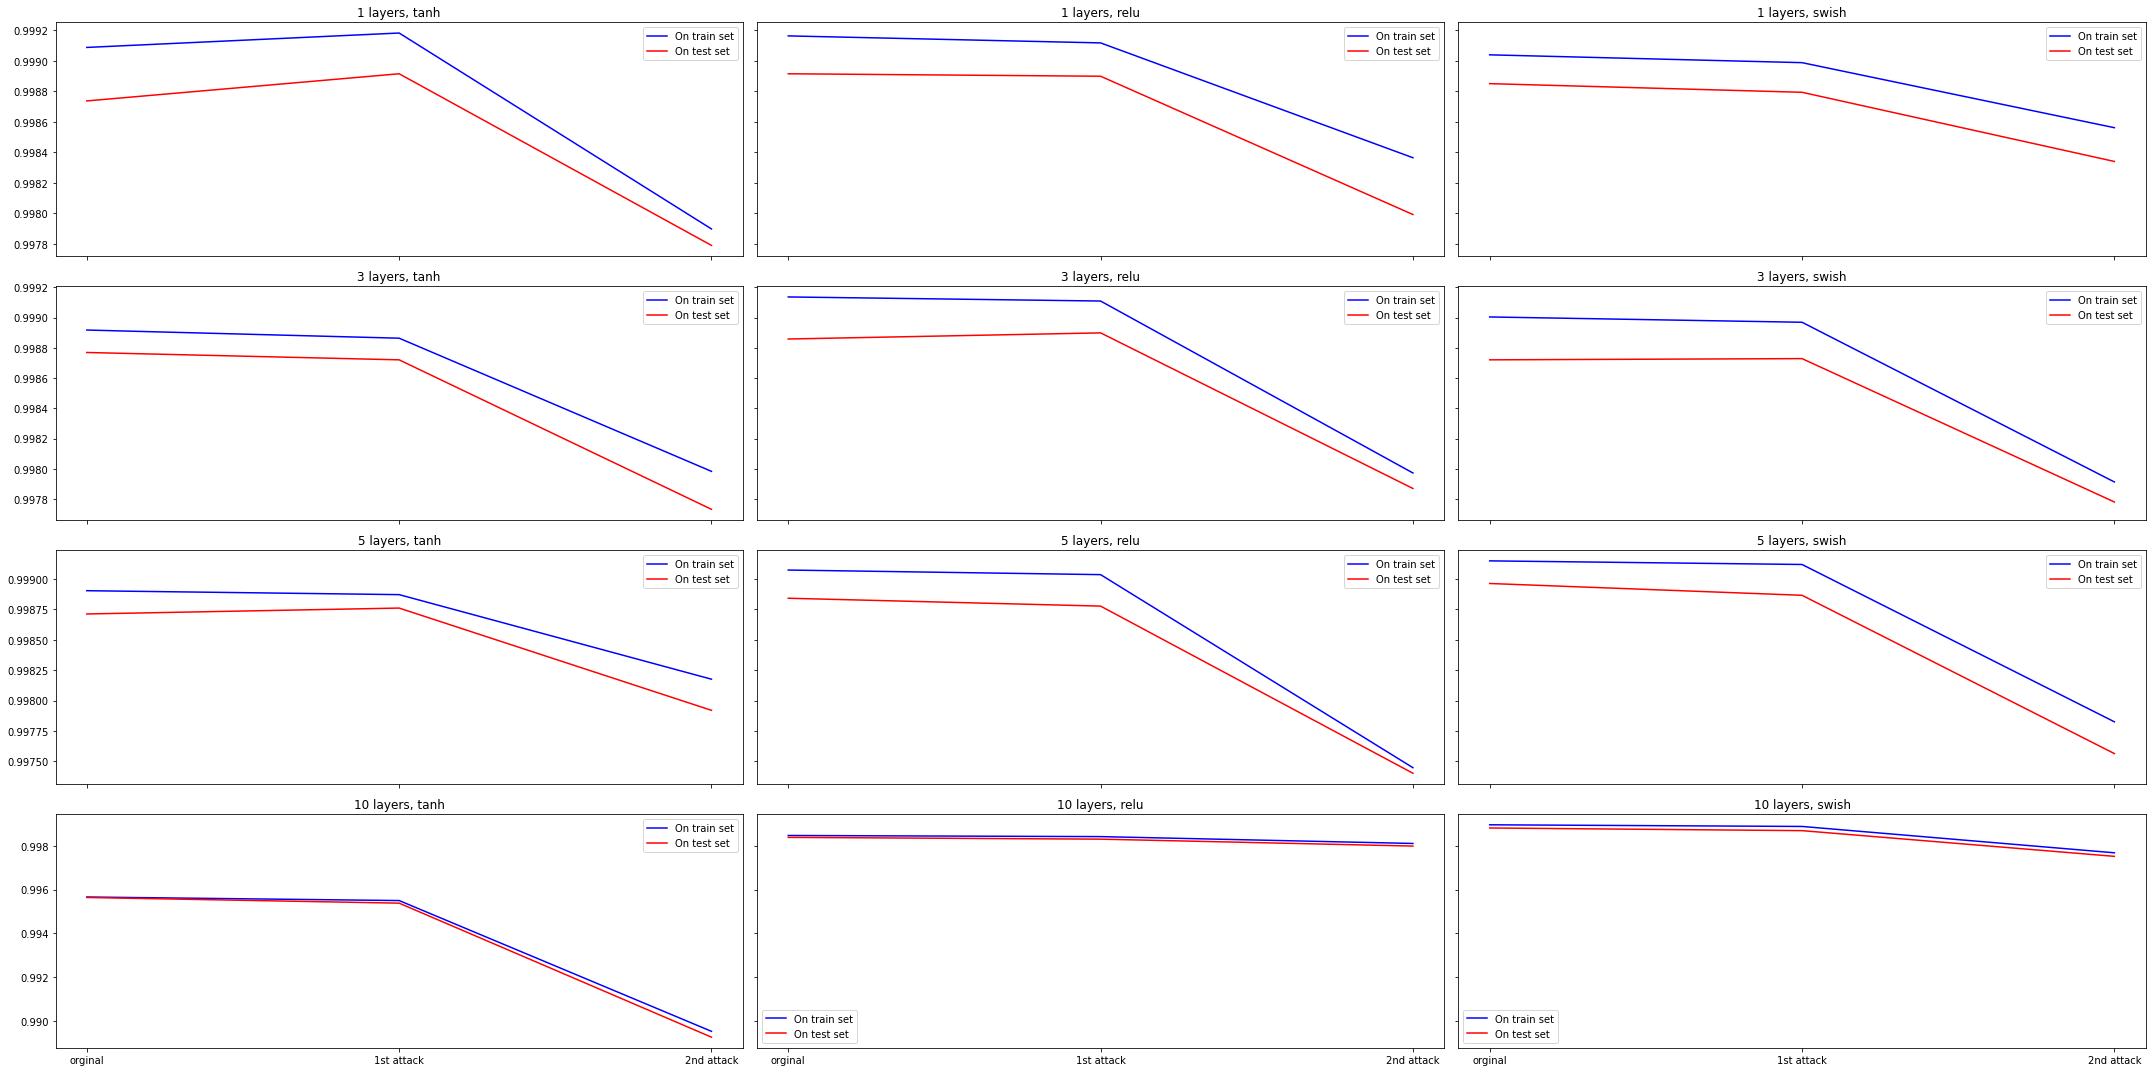

epsilon is 0.1
accuracy:


<Figure size 432x288 with 0 Axes>

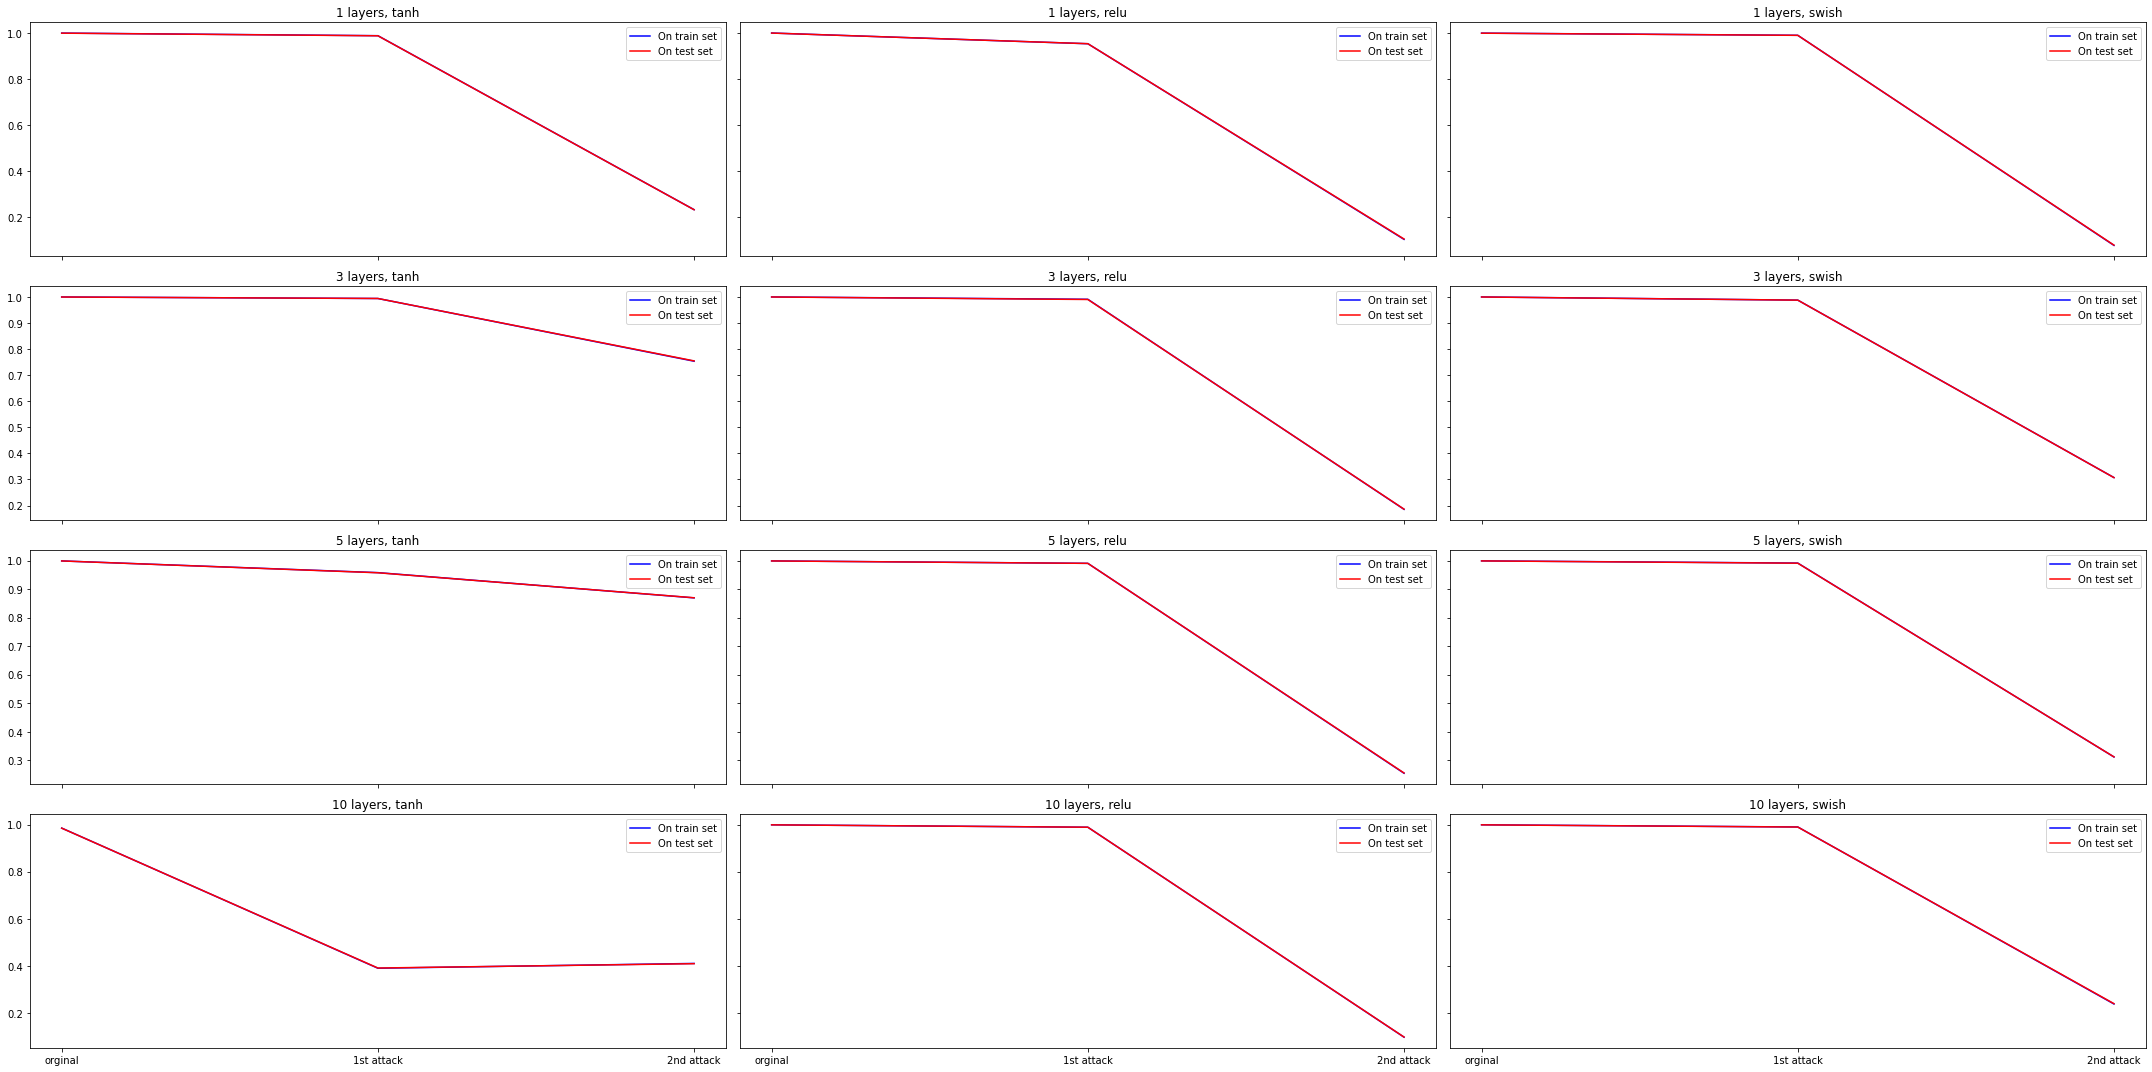

epsilon is 1
accuracy:


<Figure size 432x288 with 0 Axes>

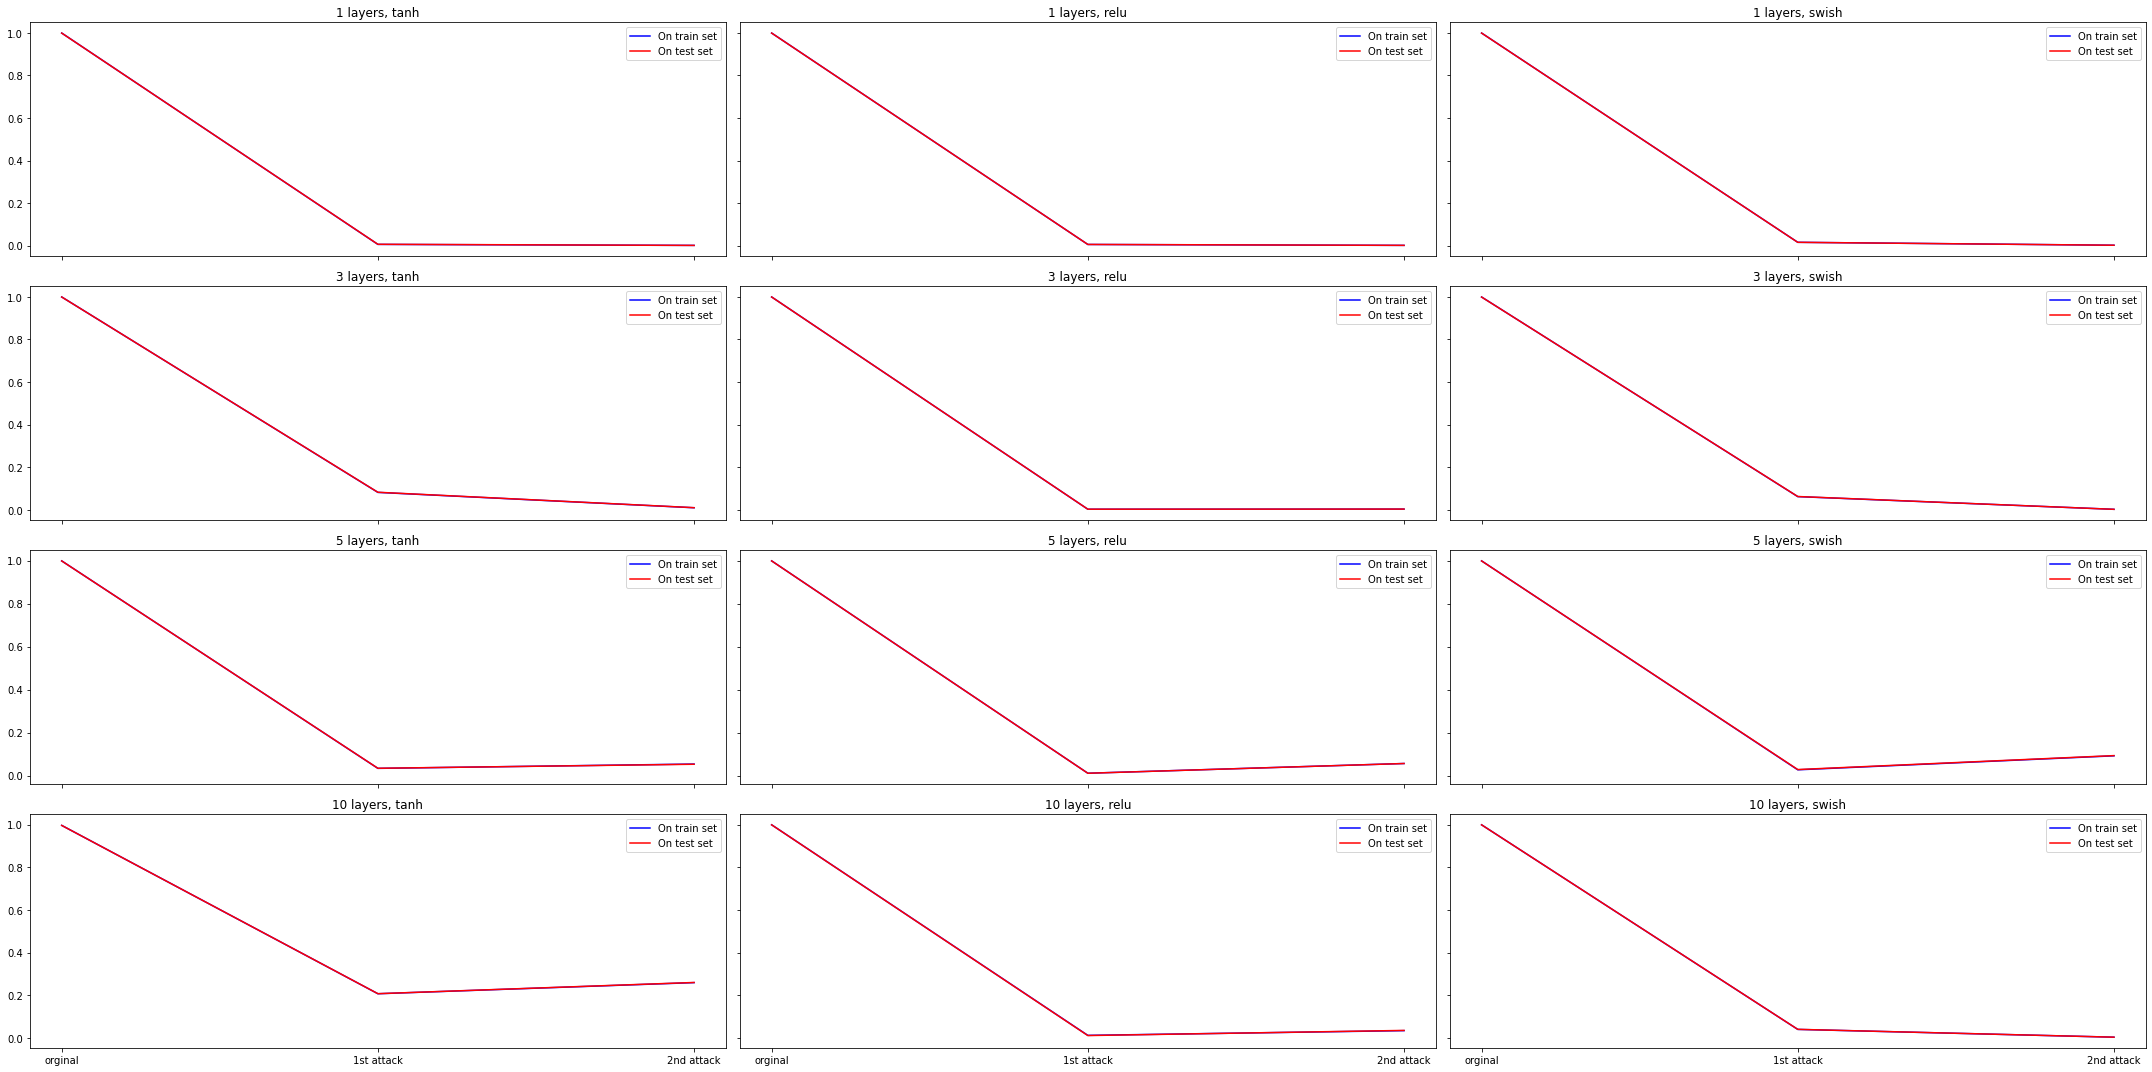

epsilon is 10
accuracy:


<Figure size 432x288 with 0 Axes>

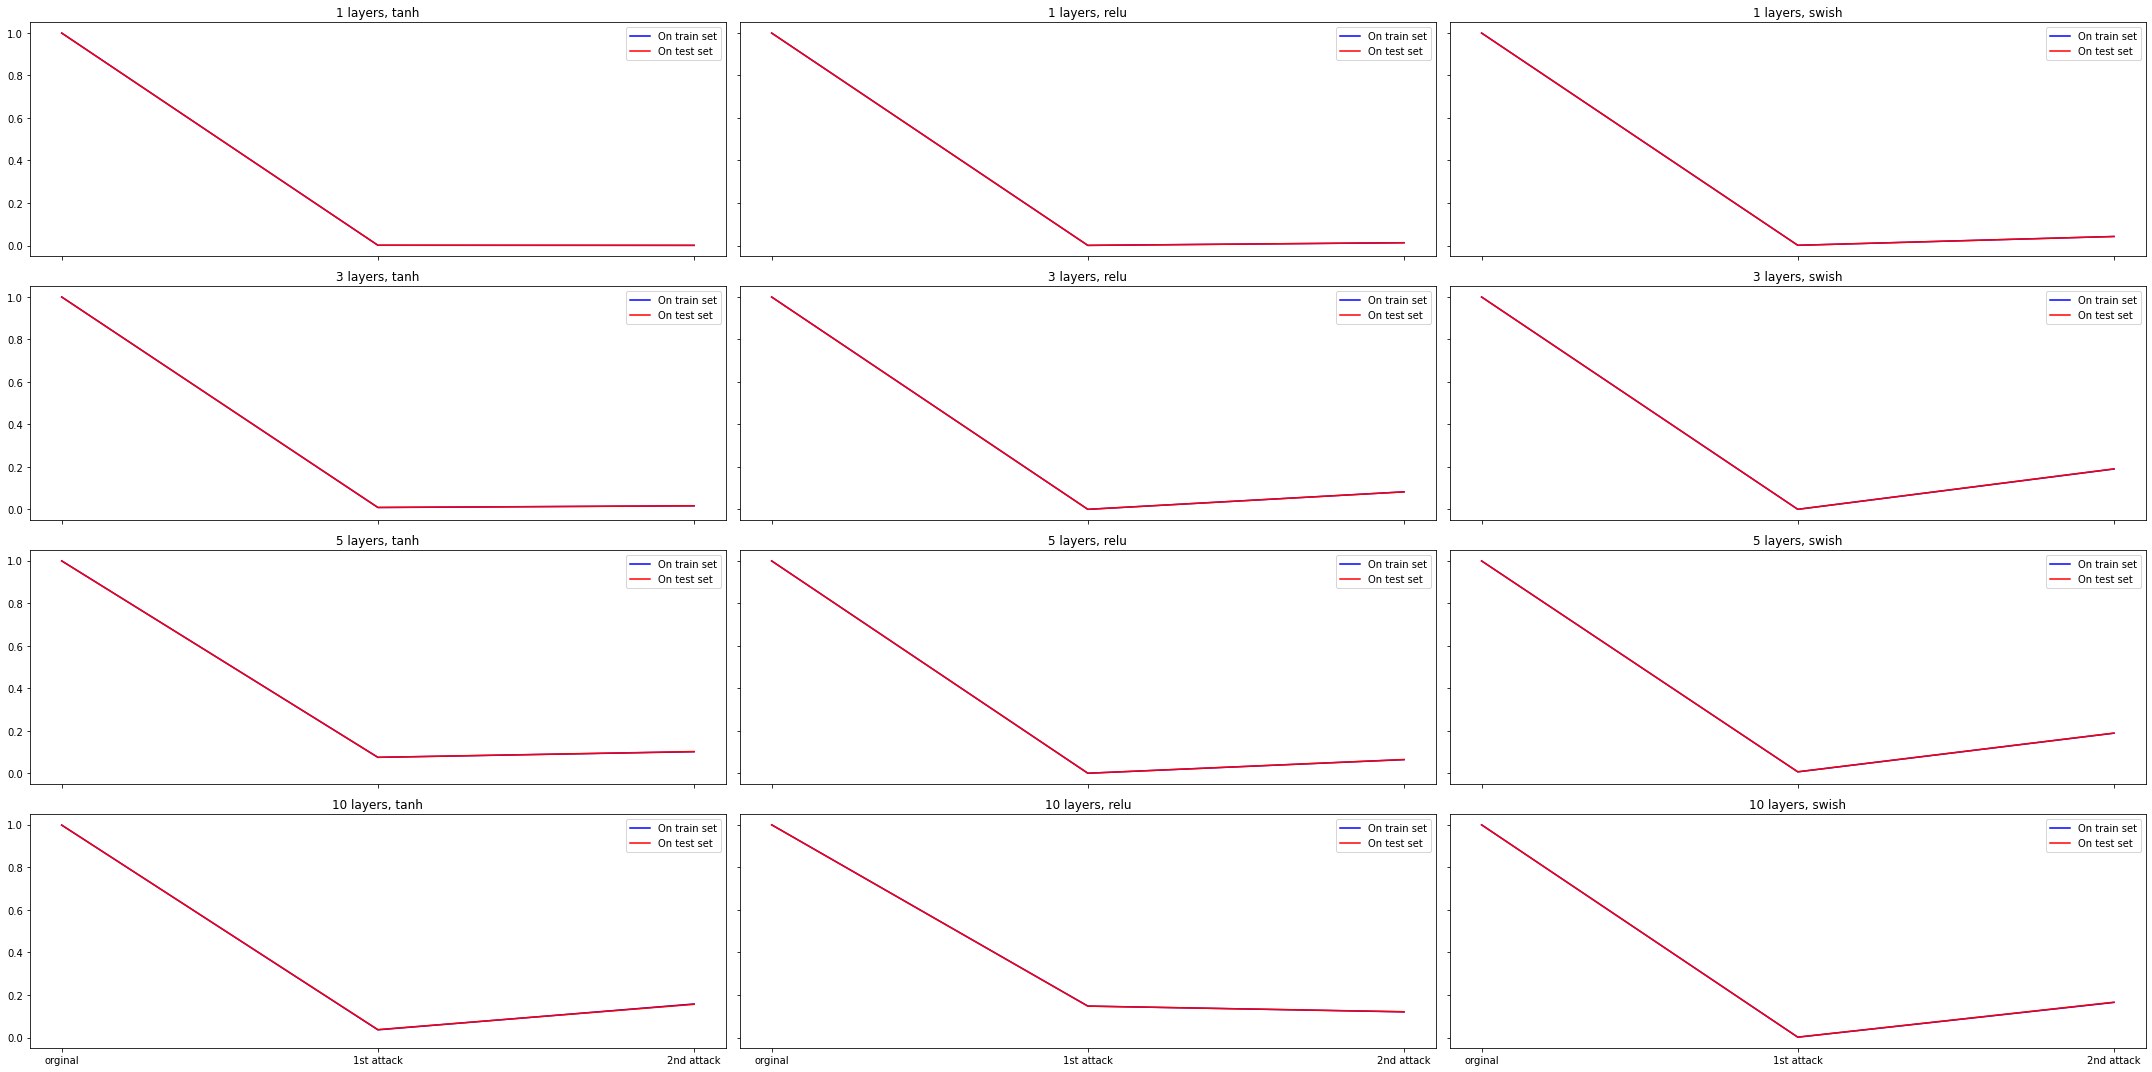

epsilon is 0.01
auc:


<Figure size 432x288 with 0 Axes>

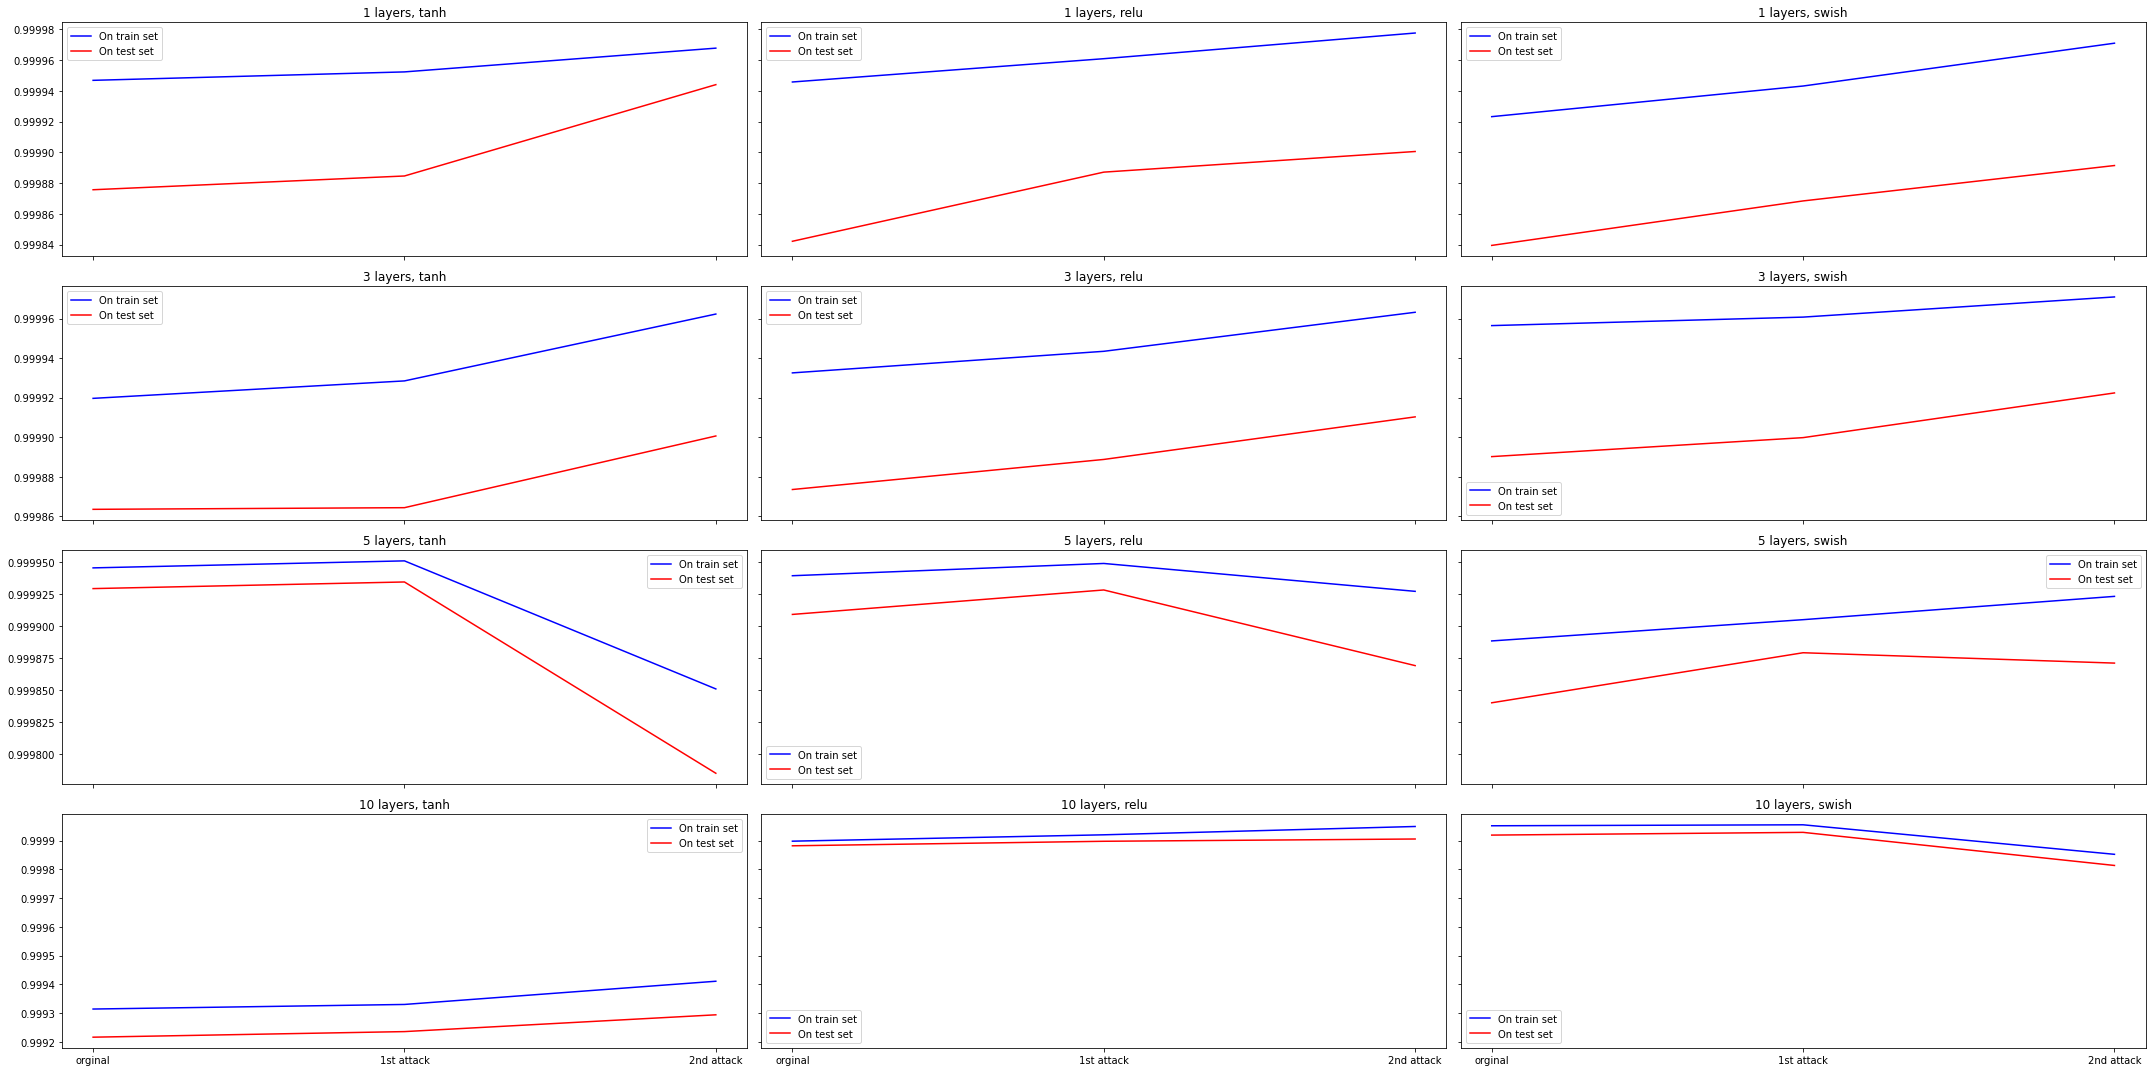

epsilon is 0.1
auc:


<Figure size 432x288 with 0 Axes>

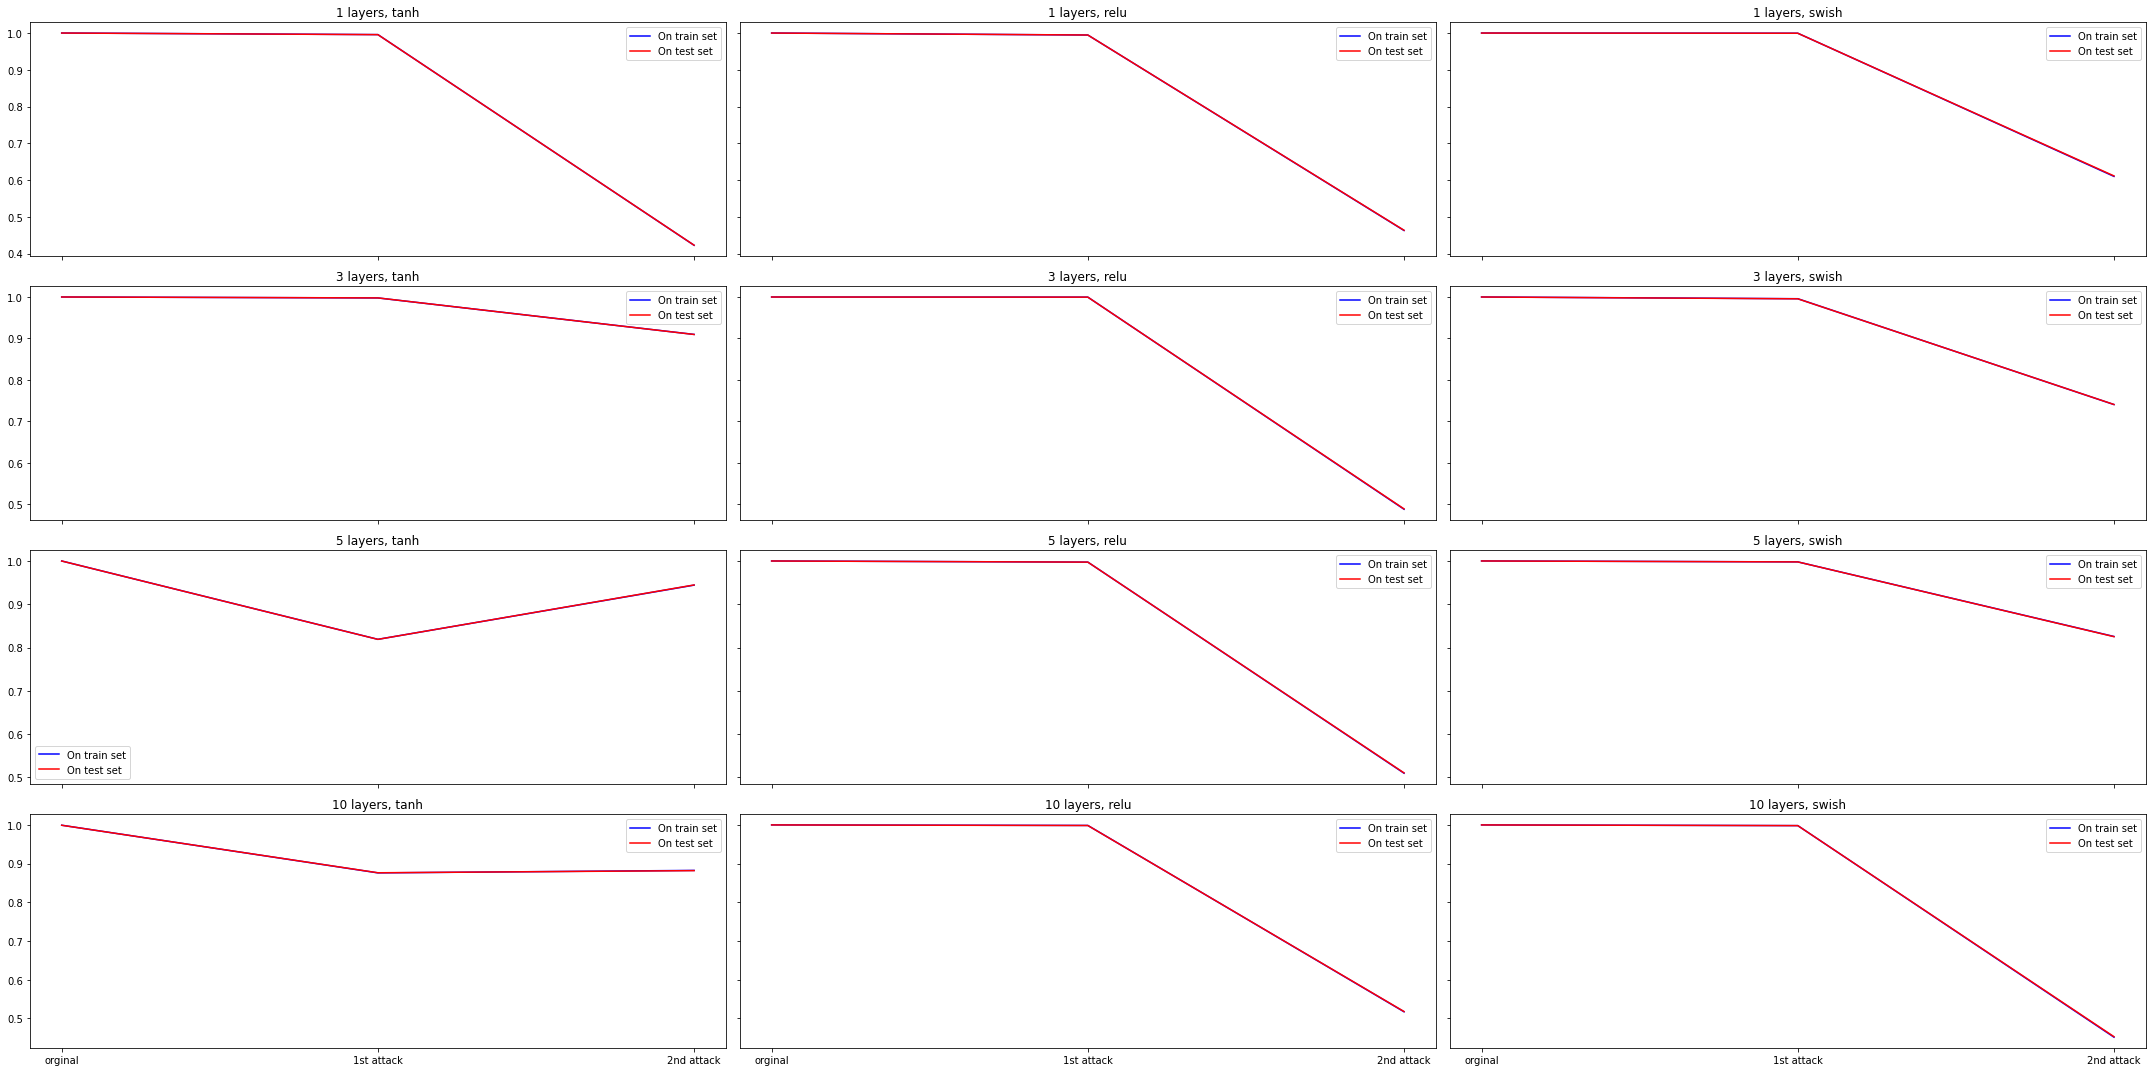

epsilon is 1
auc:


<Figure size 432x288 with 0 Axes>

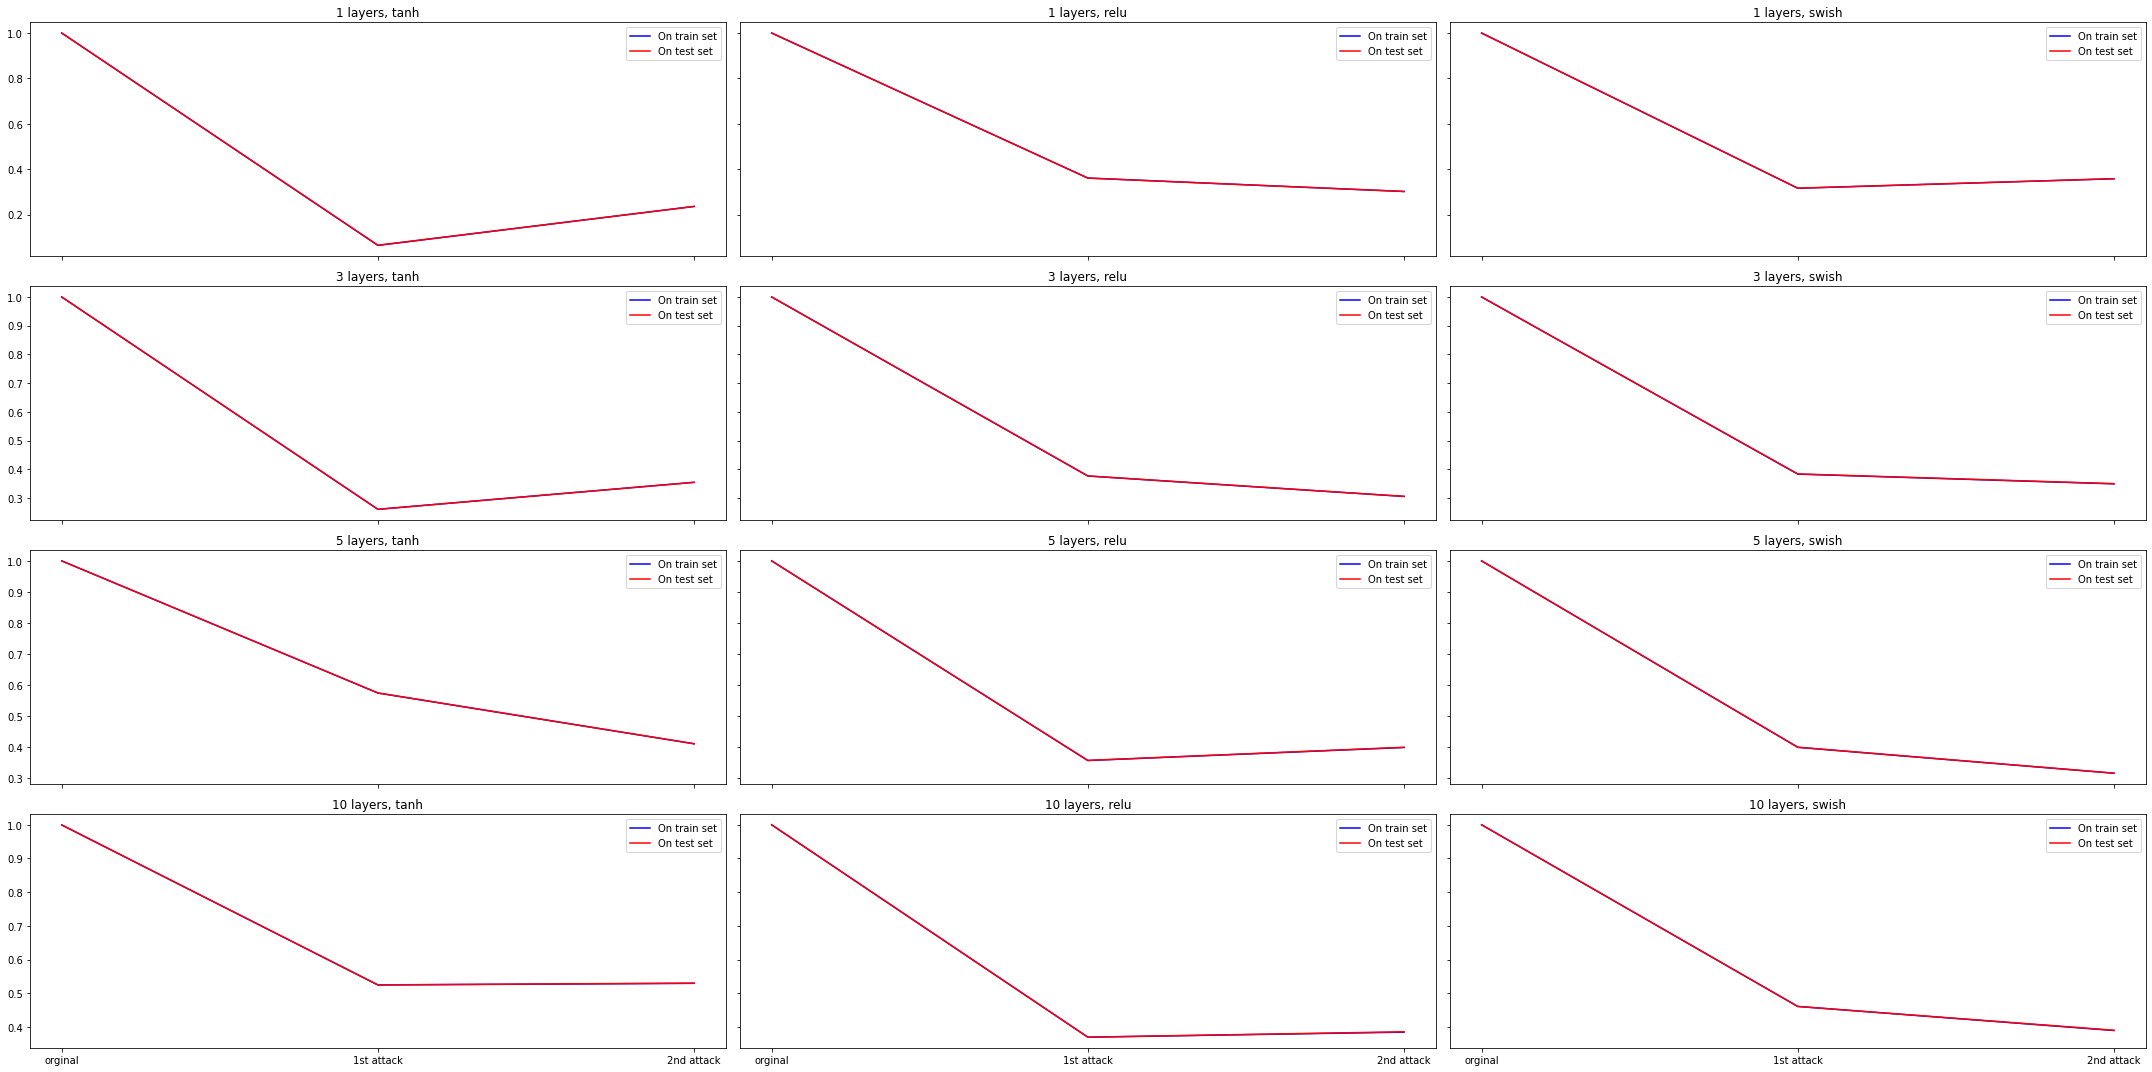

epsilon is 10
auc:


<Figure size 432x288 with 0 Axes>

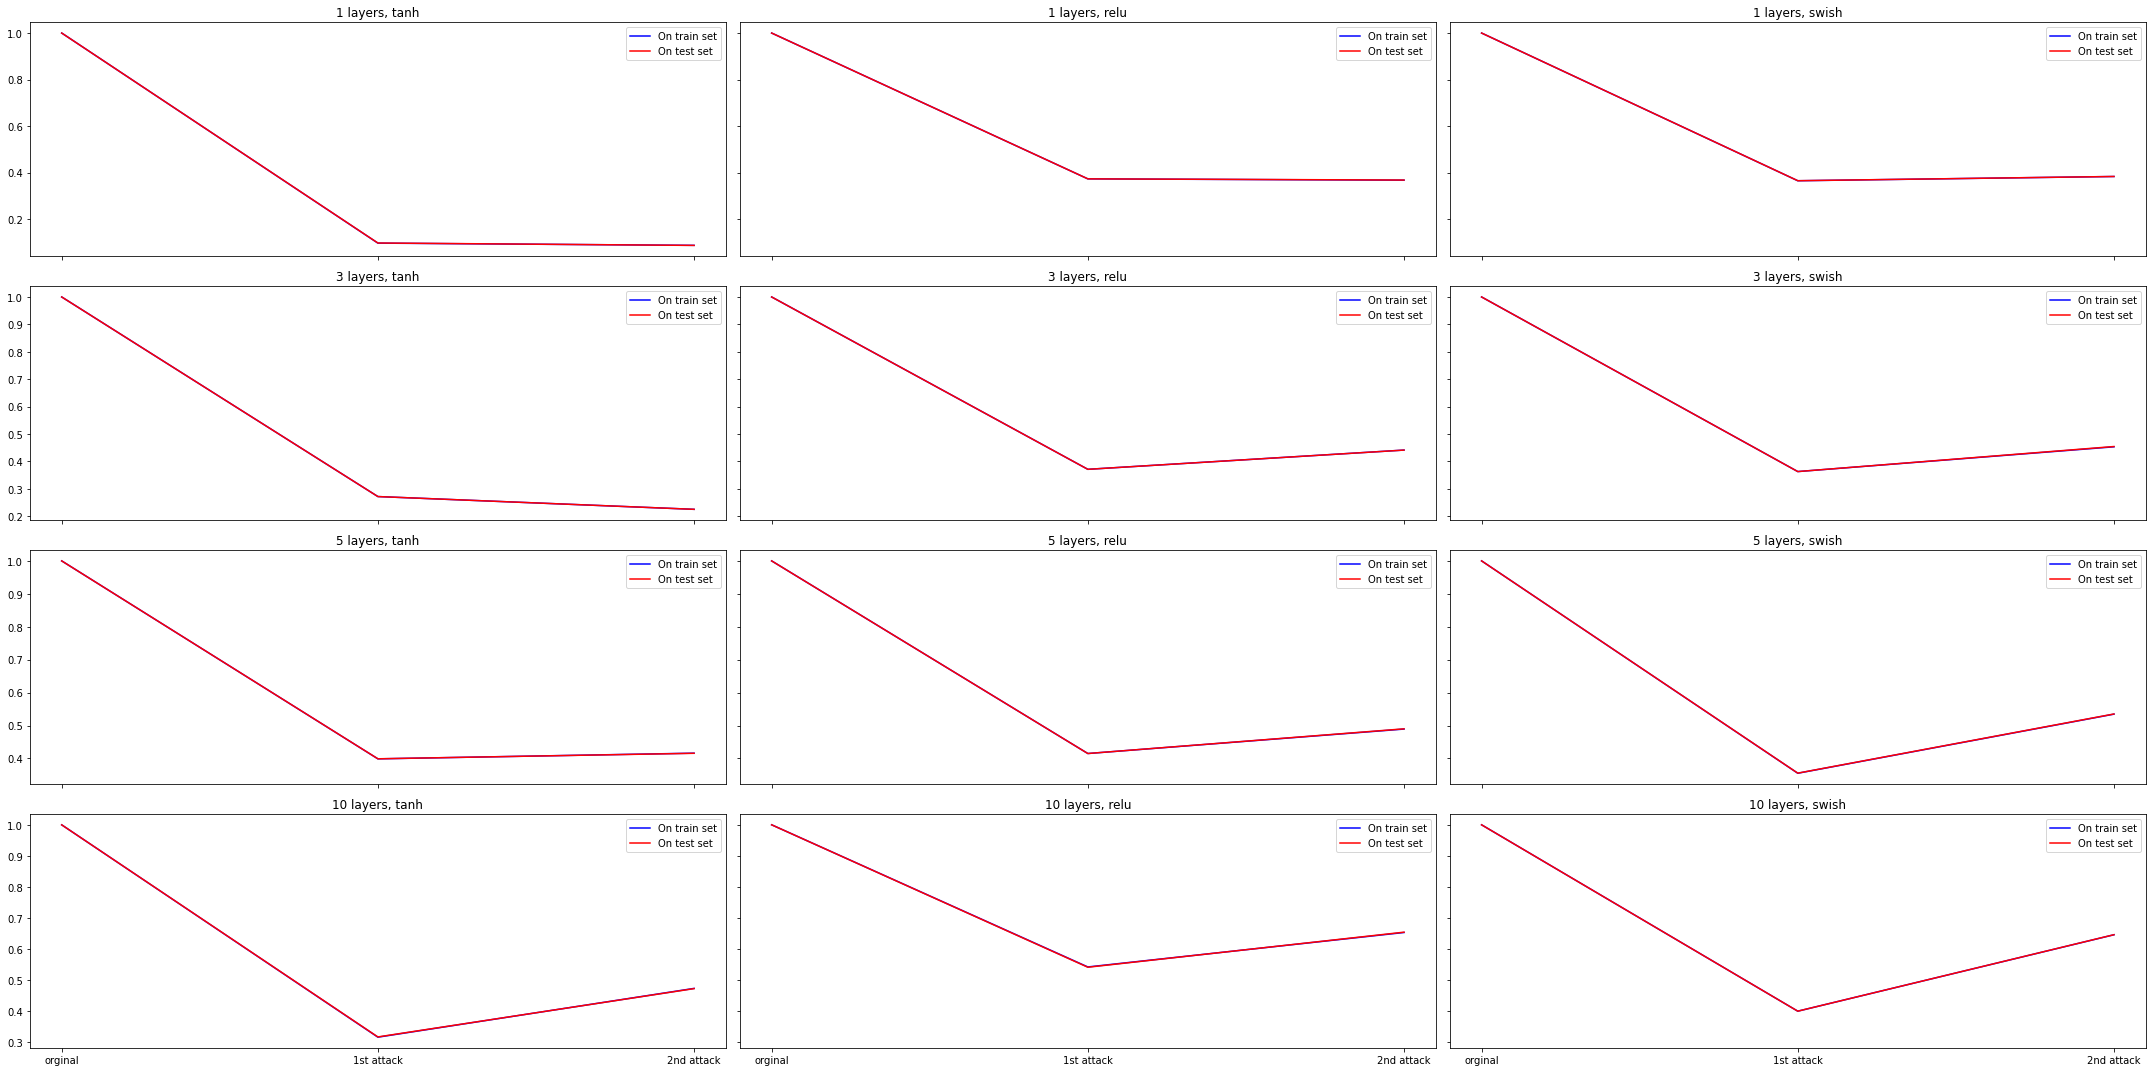

In [27]:
x = [0,1,2]
x_names = ['orginal', '1st attack','2nd attack']
for i in range(len(epsilons)):
    print('epsilon is '+str(epsilons[i]))
    print('accuracy:')
    plt.figure()
    plt.subplots(4,3,sharex='col',sharey='row',figsize=(30, 15))
    for k in range(12*i,12*(i+1)):
        layers = layers_num[int((k%12)/3)]
        activation = activations[(k%12)%3]
        ax = plt.subplot(4, 3, (k%12)+1)
        accuracy_train = [accuracy_org_train_list[k],accuracy_attack1_train_list[k], accuracy_new_train_list[k]]
        accuracy_test = [accuracy_org_test_list[k], accuracy_attack1_test_list[k], accuracy_new_test_list[k]]
        plt.plot(x,accuracy_train,'b-',label='On train set')
        plt.plot(x,accuracy_test,'r-',label='On test set')
        plt.legend()
        plt.xticks(x,x_names)
        plt.title(str(layers)+' layers, '+activation)
        plt.tight_layout()
    plt.show()

for i in range(len(epsilons)):
    print('epsilon is '+str(epsilons[i]))
    print('auc:')
    plt.figure()
    plt.subplots(4,3,sharex='col',sharey='row',figsize=(30, 15))
    for k in range(12*i,12*(i+1)):
        layers = layers_num[int((k%12)/3)]
        activation = activations[(k%12)%3]
        plt.subplot(4, 3, (k%12)+1)
        auc_train = [auc_org_train_list[k],auc_attack1_train_list[k], auc_new_train_list[k]]
        auc_test = [auc_org_test_list[k], auc_attack1_test_list[k], auc_new_test_list[k]]
        plt.plot(x,auc_train,'b-',label='On train set')
        plt.plot(x,auc_test,'r-',label='On test set')
        plt.legend()
        plt.xticks(x,x_names)
        plt.title(str(layers)+' layers, '+activation)
        plt.tight_layout()
    plt.show()


## 3 - Conclusion:

When epsilon is small (epsilon=0.01), the performances of the models with different numbers of layers and activations decreases but negligibly towards the adversarial attack. For models with 10 layers, adversarial attack decreases the accuracy by only approximately 0.1%.

When epsilon is 1, the first attack does not remarkably decrease the performance of most of the models, but the second attack after adversarial training seems to decrease robustness of the models.

When epsilon comes to 1 and 10, the attacks decrease the accuracy to less than 20%, but adversarial training seems only improve the robustness towards the second attack when epsilon=10 or when layers number is large. 

In general, three types of activation functions have no significant impact on performances against the attacks both before and after adversarial trainings. Adversarial training improves the robustness better as the number of layers increases.  



Reference: \
[1] https://en.wikipedia.org/wiki/Adversarial_machine_learning
[2] https://bdtechtalks.com/2020/07/15/machine-learning-adversarial-examples/
[] https://towardsdatascience.com/adversarial-machine-learning-mitigation-adversarial-learning-9ae04133c137